# ProjetNetwork
*Yohann Faure*  
*Flora Gaudillière*




This project aims at studying an interaction graph in the social network [Reddit](https://www.reddit.com/).<sup id="a1">[1](#f1)</sup> The data used can be found [here](http://snap.stanford.edu/data/soc-RedditHyperlinks.html).<sup id="a2">[2](#f2)</sup>



Our **main goal** is to get familiar with the data structure**s** offered by NetworkX, and to implement simple algorithms over said structures.


The code we implemented and used is available on [GitHub](https://github.com/YohannFaure/ProjetNetwork). Feel free to test the functions while reading the report.

---


## 1 - Understanding the data

### 1.1 - How reddit works

In a nutshell, Reddit allows users to create communities dedicated to a specific topic, named *subreddits*, designed by `r/their_name`. For example the subreddit `r/Cats` talks about cats. In a given subreddit, one can post images, text, or links, and redditors (users of reddit) can then either upvote (like) ou downvote (dislike) the post.

> **Example:** this is a post in `r/Cats`, by the redditor `u/STEMnet`, with a total score of ~26 700 (upvotes - downvotes). It has a unique id (c7s6ww) that allows it to be found without searching, and that appears in the web adress of the post: [reddit.com/c7s6ww](https://www.reddit.com/c7s6ww)
> ![](https://i.imgur.com/nq5wMMz.png)


### 1.2 - What is in the data

The network represents every directed connections between two subreddits, a connection being a post containing a direct hyperlink to another subreddit in the text body (there is also a title-centered dataset, feel free to reproduce our results on it). The network is extracted from publicly available Reddit data spanning 2 years and a half, from January 2014 ($t_0$) to April 2017 ($t_f$).

Each hyperlink is annotated with a value named `POST_LABEL`, which can either be $-1$ or $+1$, and that reflects the sentiment of the source post towards the target post. A value of $-1$ means the source subreddit is negatively judging the target, while $+1$ means the source is positively judging the target.

> The way the labels have been determined is detailed in [this study](http://snap.stanford.edu/conflict/), but basically, it is done using Deep Learning.
> 
> Said label is supposed reliable for most of the study, but we explore this question further in [section 6](#6---Critical-analysis-of-the-data) and assess the quality of the labeling, which often turns out not to be accurate.




The network is, by essence, directed, temporal, and attributed.

> **Example:** this post from `r/Cats` is one of the posts represented in the dataset, with a positive reference to `r/Dogs`
> ![](https://i.imgur.com/zVe5x5u.png)



> **Note:** the date in the data is wrong. For example the datestamp of `POST_ID=34c15a`, from `r/changelog` to `r/redditdev`, is `2015-04-27`, while the real datestamp of this post is `2015-04-30`.

### 1.3 - Dynamics: Interactions or relations?

This data is a collection of ponctual interactions between subreddits, but studying the frequency and the value of said interactions can lead to the construction of relations, in the way same as a relationship between two individuals can be represented as a succession of interactions.

This report is mainly focused on a relational interpretation of this dataset (we look at all combined interactions between two nodes), but an interactional (dynamic) approach is used to propose a growth model for Reddit in [this section](#44---General-time-growth-of-Reddit).

We don't take into account the creation date of a subreddit, but such information is made available in the reference paper.

---


## 2 - File conversion: `ReadTSV.py`

First, we have to work on the data conversion, *i.e.* converting the original data, stored in a `.tsv` file, into some NetworkX understandable format.

To do so, we created a python module composed of a few key functions, made specifically for this `.tsv` file format, and specialized for our data.

### 2.1 - Introducing MultiGraphs, first example

The first attempt at reading the data led to edges being written multiple times, because most subreddits have mutiple references to the same other subreddit. 
For example `r/trendingsubreddits` refered to `r/changelog` 548 times. Oviously we had to use a directed graph: if we take the same example, there is no post refering `r/trendingsubreddits` in `r/changelog`.

The high dissimetry of this specific situation is explained in this [post](https://www.reddit.com/22pz96) in `r/changelog`, created 2 days before the begining of the data collection, that mentions a new functionality added to Reddit: a new subreddit (`r/trendingsubreddits`) in which is automatically posted every day the list of the best-performing subreddits of the day. Then, each post of this subreddit contained a link to this `r/changelog` post.

> What's this? We've started displaying a small selection of [trending subreddits on the front page](https://www.reddit.com/r/changelog/comments/22pz96/reddit_change_trending_subreddits_on_the_front/). Trending subreddits are determined based on a variety of activity indicators (which are also limited to safe for work subreddits for now). Subreddits can choose to opt-out from consideration in their subreddit settings.  
><div style="text-align: right"><cite>Every post in r/trendingsubreddits</cite></div>

### 2.2 - Selecting information

In order to have a better understanding of the data, and to represent it correctly, we decided to pre-select part of the data before inserting it into the NetworkX graph. We decided to create separate keys for the `POST_ID` (which is unique accros all posts, and therefore useful to distinguish them), `TIMESTAMP` (in case we want to study a time-dependent property), and `POST_LABEL` (the positive or negative [review of the post](#12---What-is-in-the-data)).

The rest of the data is stored raw from the `.tsv` file in `POST_PROPERTIES`, just in case we need it, but we did not use it in this project.

### 2.3 - Converting the file

To convert the file, simply use the `ReadTSV` module, and call the `data_to_digraph` function on either files from [here](http://snap.stanford.edu/data/soc-RedditHyperlinks.html).

In [1]:
import networkx as nx
import ReadTSV
#help(ReadTSV)

In [2]:
G=ReadTSV.data_to_digraph('body.tsv')
print('G is of type {}, with {} nodes and {} edges'.format(type(G),len(G.nodes),len(G.edges)))

G is of type <class 'networkx.classes.multidigraph.MultiDiGraph'>, with 35776 nodes and 286561 edges


A typical post from the dataset is represented as follows:

In [3]:
G['cats']['dogs'][0]

{'POST_ID': '22j2pz',
 'TIMESTAMP': '2014-04-08 10:56:37',
 'POST_LABEL': 1,
 'POST_PROPERTIES': '891.0,739.0,0.753086419753,0.00785634118967,0.0246913580247,0.181818181818,0.0572390572391,165.0,111.0,20.0,4.18181818182,35.0,0.406060606061,9.0,8.0,97.6666666667,18.3333333333,13.1706666667,0.125,0.073,0.85,0.5240963855421686,0.12048192771084337,0.10843373493975904,0.06626506024096386,0.0,0.012048192771084338,0.03614457831325301,0.0,0.012048192771084338,0.07228915662650602,0.1566265060240964,0.0963855421686747,0.024096385542168676,0.1144578313253012,0.006024096385542169,0.03614457831325301,0.10843373493975904,0.04819277108433735,0.006024096385542169,0.05421686746987952,0.0,0.0,0.09036144578313253,0.0,0.006024096385542169,0.0,0.05421686746987952,0.04216867469879518,0.012048192771084338,0.006024096385542169,0.006024096385542169,0.0,0.1686746987951807,0.024096385542168676,0.006024096385542169,0.018072289156626505,0.04819277108433735,0.018072289156626505,0.0,0.03614457831325301,0.03012048192

---

## 3 - Getting in touch with the data structure

### 3.1 - Storing the analysis functions: `Network_Analysis.py`

We  decided to group all of our functions in a single python file called `Network_Analysis.py`. This way, a simple `import Network_Analysis as NA`
allows us to use them seamlessly in the scripts.

To get details on the content of this module, feel free to uncomment the following commands:


In [4]:
import Network_Analysis as NA
#help(NA)

### 3.2 - First approach

In order to really understand the data structure of the graph, we first wanted to plot it, but it has more than 30 000 nodes. Plotting it might therefore not be an excellent idea. The graph is indeed too large to get a proper display using NetworkX's standard `draw` method. We could imagine a drawing method based on a cut of the graph, for example we could select the higest degree nodes and only plot these.

### 3.3 - Degree distribution

To cut according to the degree of the nodes, we need to find out what the distribution of degrees is. To do so, we designed two functions called `degree_distribution`, and `Degree_distribution_plot`, that do just what their names indicate.


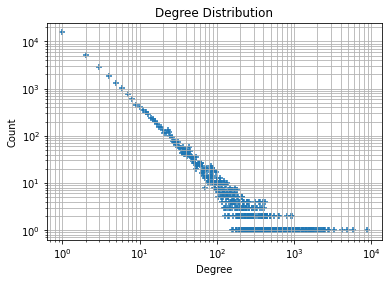

In [5]:
NA.Degree_distribution_plot(G)


![Degree_distribution_plot](https://i.imgur.com/7hfJUBq.png)


This plot is quitte interesting, as it tells us that the distribution of degrees is broad, and might be called "scale-free", according to Barabási's definition<sup id="a3">[3](#f3)</sup>. Here though, this is not a caracteristic of interest, therefore we will avoid all controversy and not call it "scale-free", just "with a broad degree distribution".


### 3.4 - Degree cutting

Now that we know that the distribution is broad, we can simply cut it on the degree, as such a cut would still preserve the overall structure of the graph, at least for visual inspection.

That is what `NA.degree_cut` does. It cuts the graph to only keep the highest degree nodes. 

> NB: One can specify the "degrees" characteristic on which to cut, making it more of a generic cut function. For example `degree_cut(G,2000,degrees=dic)` would return a graph composed of only the nodes of `G` with a score given by the dictionnary `dic` higher than 2000.

Let us plot it, using `NA.GraphDraw`. This function has a second argument that allows the selection of the interactions to plot (positive, negative, or total).



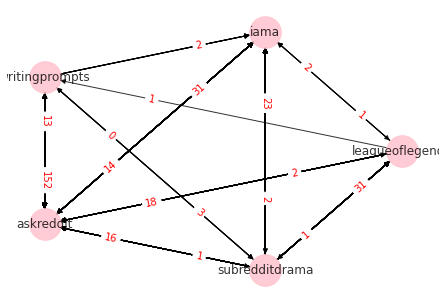

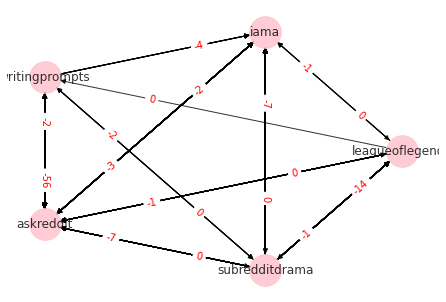

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

GG=NA.degree_cut(G,3000)
NA.GraphDraw(GG,1)
NA.GraphDraw(GG,-1)

### 3.5 - Converting to non-multi Graph

Another idea we had was to create conversion tools to make a simple Graph out of the MultiGraph. To do so, one simply needs to use `NA.MultigraphToGraph`. It allows us to better manipulate the graph.

> We also made a function to convert a Directed Graph into a simple Graph, but such manipulation looses the very essence of this dataset.

---


## 4 - Data Analysis

It is now time to answer a few questions, such as "which subreddit receives the most hate in all of reddit?", "which subreddit is the most appreciated?", or "what subreddit clusters can be found?".

### 4.1 - Simple reception metrics

We designed a set of function to find out the most loved and hated subreddits. Their usage goes as follows:


In [7]:
positive_score, negative_score=NA.positive_negative_scores(G)
total_score={i:positive_score[i]-negative_score[i] for i in positive_score}
print("Most loved, positive score: ")
most_loved = NA.Key_Max(positive_score)
print("Most hated, negative score: ")
most_hated = NA.Key_Max(negative_score)
print("Best scoring,  total score: ")
best_scoring = NA.Key_Max(total_score)

Most loved, positive score: 
askreddit 6525
Most hated, negative score: 
askreddit 804
Best scoring,  total score: 
askreddit 5721


The most hated, most loved, and best scoring subreddit is, without surprise, `r/askreddit`, a subreddit dedicated to asking questions about almost anything to Reddit users.

We might also want to find the second and third subreddits. After a few tribulations, the results are the following:

<div style="text-align: right">

| Love score | Hate score | Worst total score |
| -------- | -------- | -------- |
| r/askreddit 6525 | r/askreddit 804 |r/latterdaysaints -52 |
|r/iama 3462 |r/news 484 |r/ketorecipes -31 |
|r/pics 2533 |r/todayilearned 414 |r/femradebates -25 |
|r/writingprompts 2454 |r/worldnews 407 |r/lifeafternarcissism -19 |
|r/leagueoflegends 2251 |r/kotakuinaction 388 |r/nsfw_gifs -14 |
|r/videos 2235 |r/pics 246 |r/fitnesscirclejerk -13 |
|r/todayilearned 1957 |r/iama 232 |r/civcraftexchange -13 |
|r/worldnews 1850 |r/showerthoughts 221 |r/triviatime -11 |
|r/funny 1847 |r/videos 211 |r/idg0d -10 |
|r/nfl 1381 |r/adviceanimals 208 |r/thebatmanteam -9 |

</div>


### 4.2 - Simple emission metrics

Conversely, we might ask ourselves what are the subreddits that judge others most positively or negatively.


In [8]:
positive_score, negative_score=NA.positive_negative_scores_emitters(G)
total_score={i:positive_score[i]-negative_score[i] for i in positive_score}
print("Most loving, positive score: ")
most_loved = NA.Key_Max(positive_score)
print("Most hating, negative score: ")
most_hated = NA.Key_Max(negative_score)
print("Best scoring,   total score: ")
best_scoring = NA.Key_Max(total_score)

Most loving, positive score: 
subredditdrama 3035
Most hating, negative score: 
subredditdrama 1630
Best scoring,   total score: 
outoftheloop 1836


Unsurprisingly, the subreddit with both the highest positive and negative judgement scores is `r/subredditdrama`, a subreddit dedicated to judging other subreddits (we might add, on a positive note, that the positive judgements outweight the negatives ones by a very large margin, but this needs to be balanced by the limits of post labeling discussed in [section 6](#6---Critical-analysis-of-the-data)). 

Subreddits such as `r/drama`, `r/bestofoutrageculture` or `r/badhistory` are also groups that we could expect to find in the subreddits with the highest negative judgement scores.

<div style="text-align: right">

| Lover score | Hater score | Worst total score |
| -------- | -------- | -------- |
| r/subredditdrama 3035 | r/subredditdrama 1630 |r/shitghazisays -65 |
| r/outoftheloop 1897 | r/drama 497 | r/femrameta -56 |
| r/circlebroke 1873 |r/circlebroke 485 |  r/mubookclub -45 |
| r/shitliberalssay 1605 | r/copypasta 464 | r/hhcjcopypasta -30 |
| r/hailcorporate 1479 | r/circlejerkcopypasta 375 | r/nolibswatch -30 |
| r/writingprompts 145 | r/shitliberalssay 363 | r/iosthemes -28 |
| r/copypasta 1360 |  r/bestofoutrageculture 309 | r/wherearethefeminists -24 |
| r/buildapc 1303 | r/conspiracy 293 |  r/warcraftlore -18 |
| r/tipofmypenis 1185 | r/writingprompts 251 |  r/wowcirclejerk -15 |
| r/conspiracy 1169 | r/badhistory 219 | r/metaphotography -15 |

</div>

> Some results are a bit surprising: for example, `r/hailcorporate` appears to be a loving subreddit. Yet the description of the subreddit is
> > /r/HailCorporate is to document times when people act as unwitting advertisers for a product as well as to document what appear to be legitimate adverts via [native advertising](https://en.wikipedia.org/wiki/Native_advertising).
>
> After an inspection of its content, it clearly is a denunciation subreddit, and therefore should have a high Hater Score. For example the post with id [4isap0](http://www.reddit.com/4isap0/) is clearly a negative one. It calls out the use of native advertising to artificially boost the rating of the first Deadpool movie. Yet, it has a positive `POST_LABEL`, which means it is supposed to be a positive review.
> 
> More details on that issue [later](#5---Critical-analysis-of-the-data).

### 4.3 - Other index of importance

In order to measure the importance of a node, one could use the sum of the love and hate scores (basically the degree, as we did for the graph cut), but it would be too simple to get a deeper understanding of the graph structure of Reddit. Other centralities do exist, and computing them could be a valid extension to this project.

The most relevant centrality to apply here would be PageRank, as it was designed to solve a very similar problem.

### 4.4 - The question of normalization

A main critique one can have about these results is that the bigger a subreddit is, the higher its scores are, and therefore, some sort of normalization should be taken into account. A plausible normalization factor could be the number of redditors into the subreddit, but this information is not quite directly available as it is a time variable. An other one could be the total number of posts from this subreddit, or its posting rate, but such information would be equaly hard to obtain. An other possibility would be to normalize using the degree of the node (the subreddit), but this would lead us to ignore important information regarding the size of subreddits: for instance, we could end up with a subreddit with only a very small number of positive links and no negative links being "the most loved" subreddit, when it would only come first because of its small number of links to others.

We opted for the simple counting approach both for time constraints and ease of access to the data.


### 4.5 - General time growth of Reddit

One of the interesting things about networks is their growth. We can use this data to evaluate how fast Reddit has grown in this time scale. The basic hypothesis we made here is that the number of posts in an amount of time is proportional to the number of active members of the social network.

On the following graph, we represented in dashed lines the actual number of posts in fonction of time. The yellow line corresponds to the expected shape of such a number if the number of users was constant. It is obtained by simply approximating the curve by its tangeant at $t=t_0$. The green line is an exponential approximation of the curve, with initial and final numbers of posts fixed. Finaly the blue curve is a powerlaw fit.

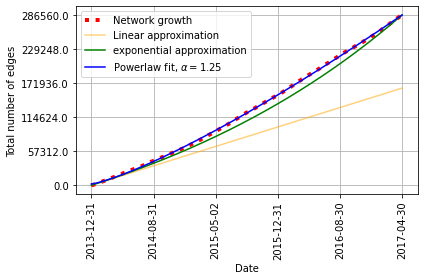

In [9]:
a,b=NA.Time_Growth(G)
NA.Plot_Time_Growth(a,b,fit=True)
plt.show()

The result here is that the powerlaw fit is clearly a better one than the exponential fit. It is interesting in itself to make predictions on the growth of Reddit, in order to prepare its infrastucture for the future, for example, but it might be interesting to compare that to the number of nodes, *i.e.* the number of subreddits.


We can compare $N(t)$ the number of subreddits to $E(t)$ the number of posts referencing them.

With more information, we could for example compute a *Densification exponent*<sup id="a4">[4](#f4)</sup> $\alpha$ (if any). Such exponent exists if there is a law:

$$
E(t)\propto N(t)^\alpha
$$

In the case of networks without multiple edges, we have $1<\alpha<2$, 1 corresponding to a tree (the minimum for the network to be convex, and therefore studied as one single network instead of two separate networks), and 2 corresponding to a clique (a densely connected graph). In our case, such exponent could be over 2 as the graph is a MultiGraph, each node can be (and usually is) connected twice or more to the same other node.


### 4.6 - An other time evolution metric

Subreddits can be created and deleted, and the number of subreddits can be used as a metric of the size of Reddit itself. We do not have access to the creation date of every subreddit, but someone looked at that in 2013.

This is a graph representation of the number of new subreddits per day, *i.e.* $\dfrac{\text{d}N}{\text{d}t}$, made available by [Randy Olson](http://www.randalolson.com/2013/03/12/retracing-the-evolution-of-reddit-through-post-data/):

![](https://i.imgur.com/1IkHd7a.png)

Sadly, this data only spans from 2006 to 2013, out of our domain of study. We tried searching for mor data, but couldn't find a proper dataset corresponding to our period of time.


---


## 5 - Communities of subreddits

### 5.1 - Position of the problem

An interesting aspect of this dataset is that it links subreddits, and can therefore describe communities, *i.e.* ensembles of subreddits that respond to one another and communicate. The goal of this section is to use the [Louvain algorithm](https://en.wikipedia.org/wiki/Louvain_method) to detect such communities.

The first problem here is that the Louvain algorithm only takes the type `Graph` as input. We could have used a community structure detection algorithm with directed graphs, but we wanted to keep things simple. We therefore had to make a data conversion.

The second problem is the the number of nodes: there are many nodes disconnected from the main connected component. Therefore, to avoid detecting useless communities of 1, 2 or 3 subreddits, we decided to only keep the nodes of highest degree. This comes with a major drawback: cutting nodes reduces the community structure of Reddit. This cut has to be at a low degree, and we decided 200 to be the cutoff. 

In [10]:
# Cutting on degree
GG=NA.degree_cut(G,600)

# Defining a weight for the edges
_,l1,l2=NA.edge_evaluation(GG)
weight={i:l1[i] for i in l1}

# Making the MultiDiGraph a Graph
GGG=NA.DiGraphToGraph(NA.MultigraphToGraph(GG,l1))

> One could argue that a connected component detection algorithm would be better, and that is very true, but the degree cutting allows for a smaller computation time and a simpler implementation, for a similar result (we tested that assumption in [section 5.5](#55---Discussion-on-the-Degree-Cut)).

### 5.2 - Creating the algorithm

The Louvain algorithm in itself stems from a module designed specifically for it:
```bash
pip3 install -U git+https://github.com/taynaud/python-louvain.git@networkx2
```

We created a Python module named `Community_Detection`, containing all the necessary functions. Once a proper graph is created, the communities can be both generated and plotted using the following:

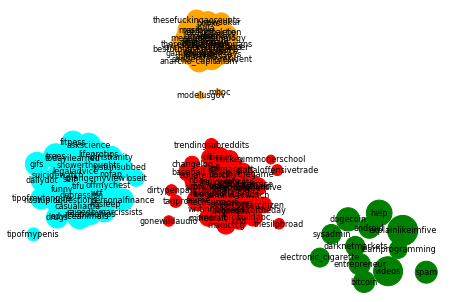

In [11]:
import Community_Detection as CD
partition = CD.plot_community(GGG)

Using a Lower degree cut we obtained this result :

```python
>>> # Cutting on degree
>>> GG=NA.degree_cut(G,200)
>>> # Defining a weight for the edges
>>> _,l1,l2=NA.edge_evaluation(GG)
>>> weight={i:l1[i] for i in l1}
>>> # Making the MultiDiGraph a Graph
>>> GGG=NA.DiGraphToGraph(NA.MultigraphToGraph(GG,l1))
>>> import Community_Detection as CD
>>> partition = CD.plot_community(GGG)
```

![](https://i.imgur.com/GPLfYz5.png)


The community structure created above is made using the positive edges only, but other weights would be conceivable.

Here the size of the circles is proportional to the degree of each node, while their position is computed using a spring layout inside the community. The details are rather boring and did not make it to the final report, feel free to read the code.

> *Some highlights on the difficulties we encountered here:*  
> We had to decide colors and size for the communities and their text, and we wanted it to be proportional to their degree. That was quite painful as NetworkX only has a partial support for such functionnalities. An other difficulty is the resolution of the image. It has to be adjusted for every network, and that can take a while.


### 5.3 - Analysis of the communities

The main observation here is that we end up with 6 macro-communities with very distinct main topics, which are listed in the table below.


| Sports (with a visible American Football sub-community on the left)| Technology (with cryptocurrencies in the top-right corner) | Free speeking (helping communities, sexuality, safe spaces) |
|---|---|---|
| ![](https://i.imgur.com/4I6mJPd.png) | ![](https://i.imgur.com/Oj9ob9J.png) | ![](https://i.imgur.com/OeAMrzo.png) |

| Video games and geek culture | Politics, Religion and News (and also conspiracies) | Humor? (this community is hard to define) |
|-|-|-|
| ![](https://i.imgur.com/YvE5Ptm.png) | ![](https://i.imgur.com/ZwpaWLq.png) | ![](https://i.imgur.com/YvEUVFa.png)|

It is interesting to note that some subreddits end up in categories one would not necessarily have expected them to, for example r/Soccer which ended up in the political community instead of the Sports community.

> This specific difference can be explained by the fact that all european countries have a dedicated subreddit, containing discussions about both European politics and sports. Soccer being more of an European sport, and the Sports subreddit being highly US-centered, with a major emphasis on American football, it is no real surprise.

### 5.4 - Limits of this community mapping

The first limit here is that some communities are really close one to an other: technology and video games are so close that `r/BuildaPCforMe` ended up in video games while being clearly closer to technology topic-wise. Likewise, some important subcommunities would deserve their own community, such as American Football.

The next major drawback is that this representation used a degree cut, and is higly dependent on that cut, as we discovered while experimenting. The higher the degree cutoff is, the worse the communities are. A simple explanation for this phenomena is that loosing small subreddits is loosing links of lenght 2 between big subreddits.

Finally this algorithm is not deterministic: it involves pseudo-random functions. Here is an other output for example, where the communities are slightly different, using the exact same function twice.

![](https://i.imgur.com/XSNlPHP.png)

### 5.5 - Discussion on the Degree Cut

The **first** comment one can make about this decision of cutting on the degree is that the chosen degree is arbitrary. To evaluate the influence of this arbitrary decision, we tested with different cutoffs, and concluded that bellow 100, it displayed "fake" communities, *i.e.* very small communities isolated from the rest of the group. Above 300, the number of subreddits considered is too small to get reliable communities, and some non-related topics started to collide.

A **second** comment can be made about the connected component cutoff: one could simply cut the graph to only keep the largest connected component. This is the result we obtained:


⚠️ Do not run the next cell if you do not want to lose 5 to 15 minutes of your life.

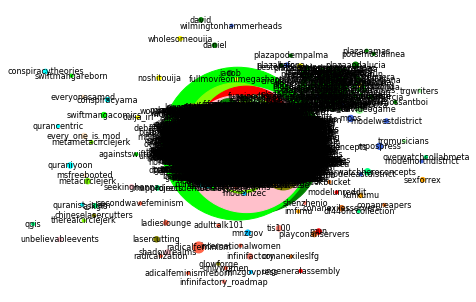

In [12]:
_,l1,l2=NA.edge_evaluation(G)
GGG=NA.DiGraphToGraph(NA.MultigraphToGraph(G,l1))
GGG=NA.Largest_Connected_Component(GGG)
partition = CD.plot_community(GGG)

The computing time is of approximately 5mn, and the result is similar to that of a too low degree cutting:

![](https://i.imgur.com/9FwouEu.png)

This is obviously not acceptable.

A **third** possibility would be to combine the degree cutoff and the connected component cutoff to avoid having small connected components adding noise to the result, while being able to go deeper in the small degree nodes. We tried, and here is the result (going bellow 50 for the degree cutoff makes the plot unreadable):



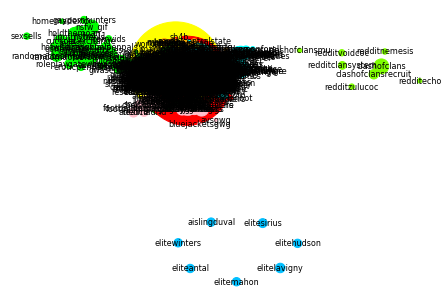

In [13]:
GG=NA.degree_cut(G,50)
_,l1,l2=NA.edge_evaluation(GG)
weight={i:l1[i] for i in l1}
GGG=NA.DiGraphToGraph(NA.MultigraphToGraph(GG,l1))
GGG=NA.Largest_Connected_Component(GGG)
partition = CD.plot_community(GGG,comscale=15.,nodscale=3.)


Alternative result:

![](https://i.imgur.com/OgyIUe6.png)

It highlights new communities, such as the pornography community at the bottom left, or the music community on the left, but it makes the central communities (which are very similar to that of [section 5.3](#53---Analysis-of-the-communities)) unreadable.

### 5.6 - Conclusion on the community structure of Reddit

The topic-wise subreddit division of Reddit makes it a very interesting playground to determine the links between different subjects in popular culture. We have achieved a stable and topic-coherent classification through this project, but as discussed in the previous paragraph, this classification is far from perfect, and many objections and improvements can be made.

The biggest issue here is that the deeper in degree cutoff we go, the harder the computation and the rendering of the results are. It is especially true when considering the whole network, as we obtain irrelevant small communities adding noise to the observation.

A direct application of such classification would be the creation of an automatic NSFW (Not Safe For Work, meaning not suitable for children or public places) classification of subreddits, protecting users from unsollicited pornographic or gore content.<sup id="a5">[5](#f5)</sup> It could also be used to propose users new subreddits they might like. This last feature has actually recently been added to the Reddit application:

![](https://i.imgur.com/HAny5yX.jpg)


> The reader might notice that Reddit proposed us a French-Speaking subreddit, meaning that it has detected that we are French. Reddit actually agressively proposes higly related subreddits to redditors, leading to an increased feeling of echo chamber effect since the implementation of this feature.

---


## 6 - Critical analysis of the data

### 6.1 - Flawed Cases

As mentionned earlier, the dataset appears to be flawed, especially on some of the evaluations of positiveness or negativeness for posts. We mentioned the example of `r/HailCorporate` being a mostly negative subreddit yet having a mostly positive emission score. This is not the only case we can find. `r/ShitLiberalsSay`, dedicated to the criticism of Liberal (~centrist-right) political views in the US, is mainly composed of users with Left Wing opinions. Yet only 6 out of its 24 references to `r/The_Donald` (a subreddit in support of D. Trump, banned from Reddit for [multiple reasons](https://en.wikipedia.org/wiki/R/The_Donald)) are considered negative, which is unrealistic.

Similarly, in `r/HateSubsInAction`, dedicated to judging the most hateful subreddits (racism, bigotry, etc.), we can find a positive review of `r/The_Donald`. This review is obviously negative ([4mbmlx](http://www.reddit.com/r/HateSubsInAction/comments/4mbmlx/fun_soviet_reactionary_thread_on_the_donald/)), but it is considered as positive by the sorting algorithm used by the authors.

### 6.2 - A proposition of explanation

After diving into the depths  of Reddit, and scrutinising the most suspicious results of our study, we found out that it was almost impossible to find a false negative review of a subreddit, while false positive are all around the corner.

Our interpretation is that the Neural Network used to determine the positivity of a post developped a very high treshold for negative reviews, considering something negative only when very explicit caracteristics appeared. Therefore, the results of community detection using the positive scores can be highly misleading, sorting together `r/The_Donald` and `r/Democrats` for example!

The Neural Network's difficulty to label posts as negative is not surprising if you consider the fact that it is very difficult to train an algorithm to recognize social cues (for instance sarcasm) that are used in posts making fun of other subreddits: without an explicit statement of negative judgement, this kind of post is sorted as "positive", completely missing the actual meaning of the interaction. 

---

## Personal conclusion on the project

This project allowed us to come to grasp with the many functionalities of NetworkX, and the concepts related to Networks and Graphs analysis studied in class. We had to dig a little deeper from time to time, reaching for other sources and discovering the Network Science field in further details.

More that a simple class project, this should make an excellent [`r/DataIsBeautiful`](https://www.reddit.com/r/dataisbeautiful/) post!

---
Notes
---

<sup id="f1">1</sup> Let's be honest, this whole Master is just an excuse to spend hours on social networks every day. [↩](#a1)

<sup id="f2">2</sup> S. Kumar, W.L. Hamilton, J. Leskovec, D. Jurafsky. Community Interaction and Conflict on the Web. World Wide Web Conference, 2018. [↩](#a2)

<sup id="f3">3</sup> Barabási, Réka. Emergence of Scaling in Random Networks, 1999. [↩](#a3)

<sup id="f4">4</sup> J. Leskovec, J. Kleinberg, C. Faloutsos. Graphs over time: densification laws, shrinking diameters and possible explanations, 2005. [↩](#a4)

<sup id="f5">5</sup> Such classification in Reddit exists, but it is rather based on the sincerity of redditors, and the moderation of each subreddit by "super-users" called *mods* (moderators). Relying on users to decide what is NSFW and what is not is bound to create problems, but usually works when combined with the NSFW post detection bot. [↩](#a5)
